<a href="https://colab.research.google.com/github/angela-maennel/Brain-Tumor-Detection/blob/main/brainTumors_preliminary_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **Unizip file**

In [ ]:
!unzip "/content/drive/My Drive/brain_tumors.zip" -d "/content"

Streaming output truncated to the last 5000 lines.
  inflating: /content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: /content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: /content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: /content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: /content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: /content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: /content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: /content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: /content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_

# **Imports**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import re
import zipfile
from PIL import Image
from sklearn.utils import shuffle
import keras
import tensorflow as tf
import os

from keras import backend as K 


In [ ]:
# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def show_image(x):
  plt.imshow(x, cmap='gray', interpolation='none')
  plt.show()

def show_pair(image,label):
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.imshow(image, cmap='gray', interpolation='none')
  ax2.imshow(label, cmap='gray', interpolation='none')
  plt.show()

# **Upload data**

In [ ]:
file_name = '/content/kaggle_3m'

In [ ]:
df = pd.read_csv(file_name+'/data.csv')

In [ ]:
df.set_index('Patient',inplace = True)
df['number_of_images'] = 0
df['folder'] = ''
patients = list(df.index)

In [ ]:
list_of_files =  os.listdir(file_name)
for patient in patients:
  for name in list_of_files:
    if patient in name:
      m = re.search(patient+'_'+'[0-9]{8}',name)
      df.loc[patient,'folder'] = m.group()
      break   

In [ ]:
image_files = []
label_files = []

In [ ]:
for patient in patients:
  number_of_images = 0 
  folder_name = '/content/kaggle_3m/'+ df.loc[patient,'folder'] 
  file_list = os.listdir(folder_name)
  for file in file_list:
    if 'mask' in file:
      number_of_images+=1
      label_files.append(folder_name+'/'+file)
      image_files.append(folder_name+'/'+file[:-9]+'.tif')
  
  df.loc[patient,'number_of_images'] = number_of_images 


In [ ]:
total_images=df['number_of_images'].sum()

In [ ]:
total_images

3929

In [ ]:
len(image_files),len(label_files)

(3929, 3929)

In [ ]:
image_files,label_files = shuffle(image_files,label_files)
X_train_list, y_train_list  = image_files[:2947], label_files[:2947]
X_val_list, y_val_list = image_files[2947:3536], label_files[2947:3536]
X_test_list,y_test_list = image_files[3536:], label_files[3536:]

# **Data Generator**

In [ ]:
class Custom_Generator(keras.utils.Sequence) :
  
  def __init__(self, image_filenames, label_filenames, batch_size):
    self.image_filenames = image_filenames
    self.label_filenames = label_filenames
    self.batch_size = batch_size
    
    
  def __len__(self) :
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)  
  
  def __getitem__(self, idx) :
    batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.label_filenames[idx * self.batch_size : (idx+1) * self.batch_size]

    X = np.array([np.array(Image.open(file)) for file in batch_x])/255.0
    y = np.array([np.array(Image.open(file)) for file in batch_y])/255.0
   
    return X,y

In [ ]:
def load_images(image_names,label_names):
  X = np.array([np.array(Image.open(file)) for file in image_names])/255.0
  y = np.array([np.array(Image.open(file)) for file in label_names])/255.0
  return X,y

In [ ]:
batch_size =15

my_training_batch_generator = Custom_Generator(X_train_list, y_train_list, batch_size)
my_validation_batch_generator = Custom_Generator(X_val_list, y_val_list, batch_size)

In [ ]:
X,y = my_training_batch_generator.__getitem__(0)

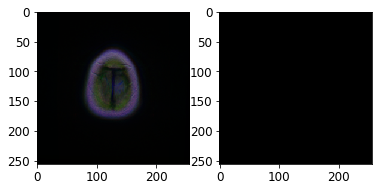

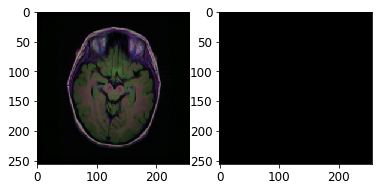

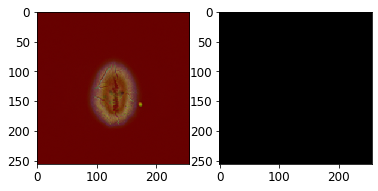

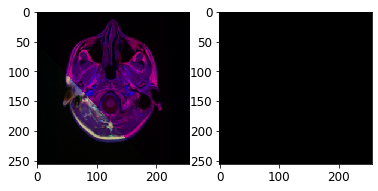

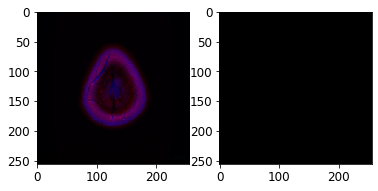

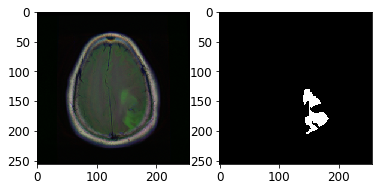

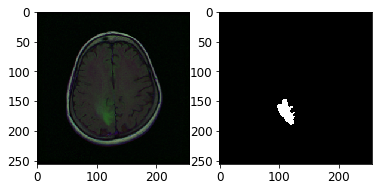

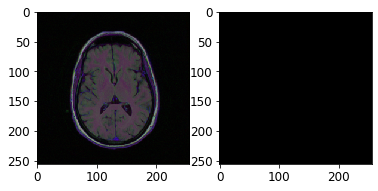

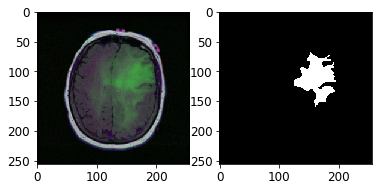

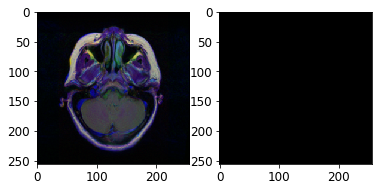

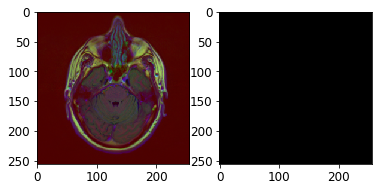

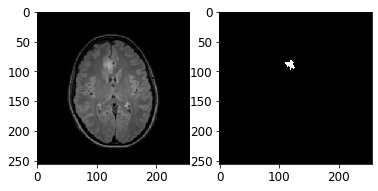

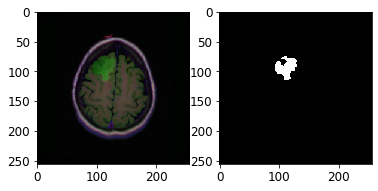

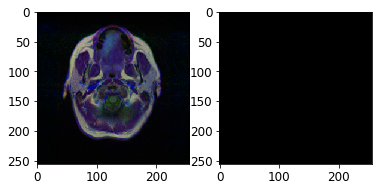

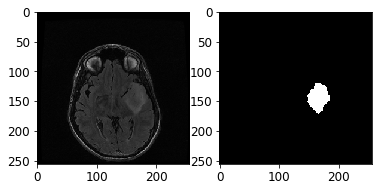

In [ ]:
for i in range(15):
  show_pair(X[i],y[i])

In [ ]:
%%timeit
X,y = my_training_batch_generator.__getitem__(0)

10 loops, best of 3: 19.7 ms per loop


# **Neural Network**

In [ ]:
encoder = tf.keras.applications.VGG16(
    include_top=False, input_shape = (256,256,3)
)

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
regulization = 5e-5
regulizer = tf.keras.regularizers.L2(l2=regulization)

In [ ]:
up1 = keras.layers.concatenate([keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(encoder.layers[-1].output), encoder.layers[-2].output], axis=3)
conv1_a = keras.layers.Conv2D(512, (3, 3), name = 'conv_1a', activation='relu', padding='same',kernel_regularizer = regulizer, kernel_initializer='he_normal')(up1)
norm1_a = keras.layers.BatchNormalization(name = 'norm_1a')(conv1_a)
conv1_b = keras.layers.Conv2D(512, (3, 3), name = 'conv_1b', activation='relu', padding='same',kernel_regularizer = regulizer, kernel_initializer='he_normal')(norm1_a)
norm1_b = keras.layers.BatchNormalization(name = 'norm_1b')(conv1_b)

up2 = keras.layers.concatenate([keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(norm1_b), encoder.layers[-6].output], axis=3)
conv2_a = keras.layers.Conv2D(512, (3, 3), name = 'conv_2a', activation='relu', padding='same',kernel_regularizer = regulizer, kernel_initializer='he_normal')(up2)
norm2_a = keras.layers.BatchNormalization(name = 'norm_2a')(conv2_a)
conv2_b = keras.layers.Conv2D(512, (3, 3), name = 'conv_2b', activation='relu', padding='same',kernel_regularizer = regulizer, kernel_initializer='he_normal')(norm2_a)
norm2_b = keras.layers.BatchNormalization(name = 'norm_2b')(conv2_b)

up3 = keras.layers.concatenate([keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(norm2_b), encoder.layers[-10].output], axis=3)
conv3_a = keras.layers.Conv2D(256, (3, 3),name = 'conv_3a', activation='relu', padding='same',kernel_regularizer = regulizer, kernel_initializer='he_normal')(up3)
norm3_a = tf.keras.layers.BatchNormalization(name = 'norm_3a')(conv3_a)
conv3_b = keras.layers.Conv2D(256, (3, 3),name = 'conv_3b', activation='relu', padding='same',kernel_regularizer = regulizer, kernel_initializer='he_normal')(norm3_a)
norm3_b = tf.keras.layers.BatchNormalization(name = 'norm_3b')(conv3_b)

up4 = keras.layers.concatenate([keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(norm3_b), encoder.layers[-14].output], axis=3)
conv4_a = keras.layers.Conv2D(64, (3, 3),name = 'conv_4a', activation='relu', padding='same',kernel_regularizer = regulizer, kernel_initializer='he_normal')(up4)
norm4_a = tf.keras.layers.BatchNormalization(name = 'norm_4a')(conv4_a)
conv4_b = keras.layers.Conv2D(64, (3, 3),name = 'conv_4b', activation='relu', padding='same',kernel_regularizer = regulizer, kernel_initializer='he_normal')(norm4_a)
norm4_b = tf.keras.layers.BatchNormalization(name = 'norm_4b')(conv4_b)

up5 = keras.layers.concatenate([keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(norm4_b), encoder.layers[-17].output], axis=3)
conv5_a = keras.layers.Conv2D(32, (3, 3),name = 'conv_5a', activation='relu', padding='same',kernel_regularizer = regulizer, kernel_initializer='he_normal')(up5)
norm5_a = tf.keras.layers.BatchNormalization(name = 'norm_5a')(conv5_a)
conv5_b = keras.layers.Conv2D(32, (3, 3),name = 'conv_5b', activation='relu', padding='same',kernel_regularizer = regulizer, kernel_initializer='he_normal')(norm5_a)
norm5_b = tf.keras.layers.BatchNormalization(name = 'norm_5b')(conv5_b)

output_ = keras.layers.Conv2D(1, (1, 1), name='output', activation='sigmoid')(norm5_b)



In [ ]:
model = keras.Model(inputs=[encoder.input],outputs=[output_])
# mark some layers as not trainable
model.get_layer('block1_conv1').trainable = False
model.get_layer('block1_conv2').trainable = False
model.get_layer('block2_conv1').trainable = False
model.get_layer('block2_conv2').trainable = False
model.get_layer('block3_conv1').trainable =  False
model.get_layer('block3_conv2').trainable =  False
model.get_layer('block3_conv3').trainable =  False

# **Loss functions and Metrics**

In [ ]:
def dice_loss(y_true, y_pred):
    true = K.flatten(y_true)
    pred = K.flatten(y_pred)
    intersection=K.sum(true*pred)
    return -(2. * intersection + 0.001) / (K.sum(true) +K.sum(pred) + 0.001)

In [ ]:
def dice_coef(y_true,y_pred):
    true = K.flatten(y_true)
    pred = K.flatten(y_pred)
    intersection = K.sum(true*pred)
    return (2. * intersection + 0.001) / (K.sum(true) + K.sum(pred) + 0.001)

In [ ]:
def  IoU(y_true,y_pred): #Intersection over Union
  true = K.flatten(y_true)
  pred = K.flatten(y_pred)
  intersection = K.sum(true*pred)
  return (intersection + 0.001) / (K.sum(true) + K.sum(pred) - intersection + 0.001)

# **Train Model**

In [ ]:
opt = tf.keras.optimizers.Nadam(learning_rate=0.005, beta_1=0.9, beta_2=0.999)
model.compile(loss=dice_loss, optimizer=opt, metrics=[dice_coef,IoU,'accuracy'])

In [ ]:
result = model.fit(my_training_batch_generator,
                  epochs=7,validation_data = my_validation_batch_generator)


Epoch 1/7
197/197 [==============================] - 118s 523ms/step - loss: -0.1656 - dice_coef: 0.2214 - IoU: 0.1417 - accuracy: 0.8568 - val_loss: -0.3141 - val_dice_coef: 0.3912 - val_IoU: 0.2545 - val_accuracy: 0.9788
Epoch 2/7
197/197 [==============================] - 102s 518ms/step - loss: -0.4391 - dice_coef: 0.5251 - IoU: 0.3770 - accuracy: 0.9913 - val_loss: -0.5079 - val_dice_coef: 0.5780 - val_IoU: 0.4263 - val_accuracy: 0.9928
Epoch 3/7
197/197 [==============================] - 104s 529ms/step - loss: -0.5535 - dice_coef: 0.6134 - IoU: 0.4630 - accuracy: 0.9933 - val_loss: -0.5556 - val_dice_coef: 0.6187 - val_IoU: 0.4685 - val_accuracy: 0.9932
Epoch 4/7
197/197 [==============================] - 105s 536ms/step - loss: -0.6046 - dice_coef: 0.6553 - IoU: 0.5033 - accuracy: 0.9938 - val_loss: -0.5446 - val_dice_coef: 0.6180 - val_IoU: 0.4677 - val_accuracy: 0.9934
Epoch 5/7
197/197 [==============================] - 105s 536ms/step - loss: -0.6132 - dice_coef: 0.6709 - I

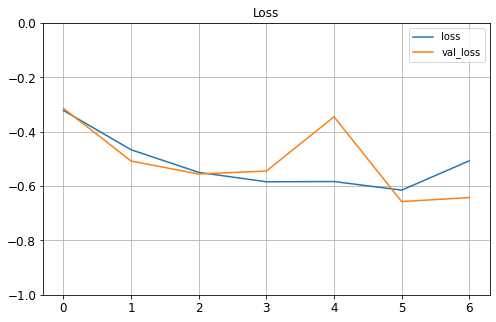

In [ ]:
pd.DataFrame(result.history)[['loss','val_loss']].plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(-1,0)
plt.title('Loss')
plt.show()

# **Analyze Errors**

In [ ]:
X_test,y_test = load_images(X_test_list,y_test_list)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
def percision(y_true,y_pred):
  y_guess = y_pred
  y_guess[y_guess>0.5] = 1
  y_guess[y_guess<=0.5] = 0
  true_positives = (y_true*y_guess).sum()
  denominator = y_guess.sum()
  if denominator ==0:
    return 1
  return true_positives/denominator

In [ ]:
def recall(y_true,y_pred):
  y_guess = y_pred
  y_guess[y_guess>0.5] = 1
  y_guess[y_guess<=0.5] = 0
  true_positives = (y_true*y_guess).sum()
  denominator = y_test.sum()
  if denominator ==0:
    return 1
  return true_positives/denominator

In [ ]:
y_pred  = y_pred.squeeze()

In [ ]:
recall_values = [recall(y_test[i],y_pred[i]) for i in range(len(y_test))]
percision_values = [percision(y_test[i],y_pred[i]) for i in range(len(y_test))]

In [ ]:
recall(y_test,y_pred),percision(y_test,y_pred)

(0.7052985994203301, 0.7830656225432011)

In [ ]:
sum(recall_values)/len(recall_values),sum(percision_values)/len(percision_values)

(0.0017946529247336645, 0.8878814631758595)

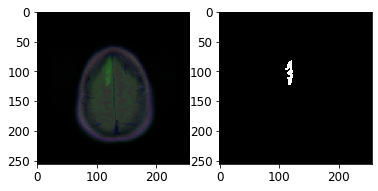

Prediction:


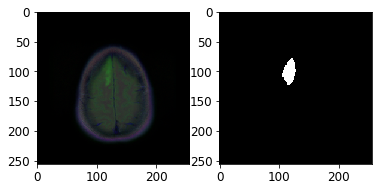

Percision:  0.4335766423357664  Recall:  0.0010309099429007791




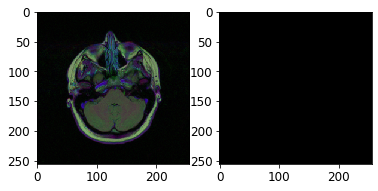

Prediction:


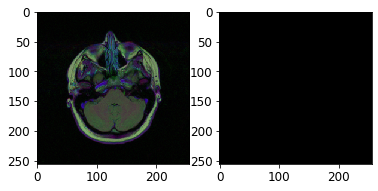

Percision:  1  Recall:  0.0




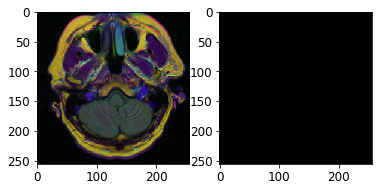

Prediction:


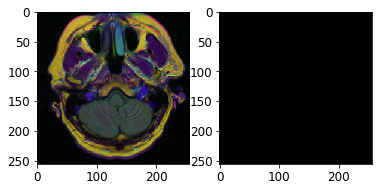

Percision:  1  Recall:  0.0




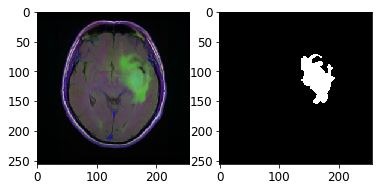

Prediction:


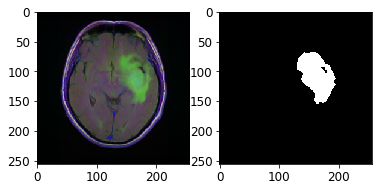

Percision:  0.7691415313225058  Recall:  0.009205296863881706




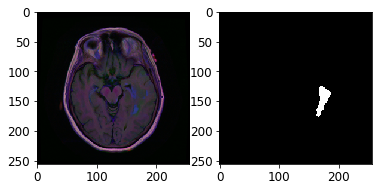

Prediction:


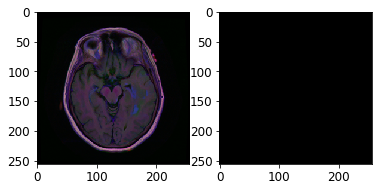

Percision:  1  Recall:  0.0




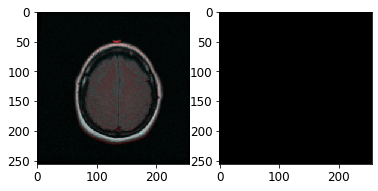

Prediction:


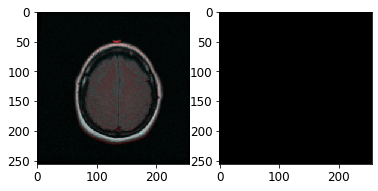

Percision:  1  Recall:  0.0




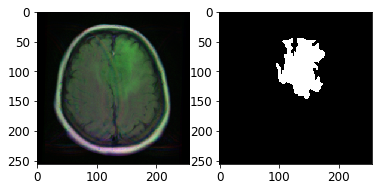

Prediction:


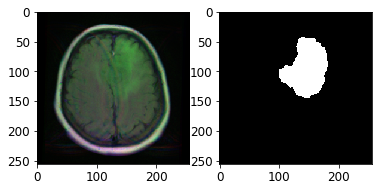

Percision:  0.7990680335507921  Recall:  0.014880508165709228




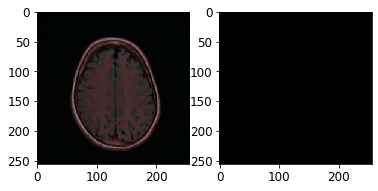

Prediction:


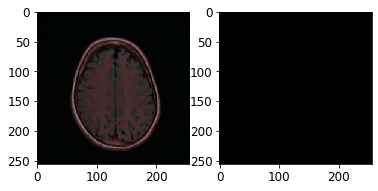

Percision:  1  Recall:  0.0




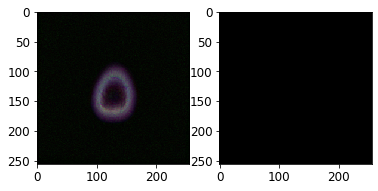

Prediction:


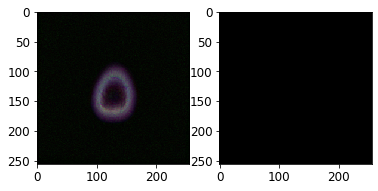

Percision:  1  Recall:  0.0




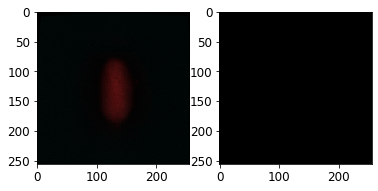

Prediction:


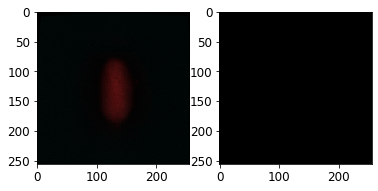

Percision:  1  Recall:  0.0




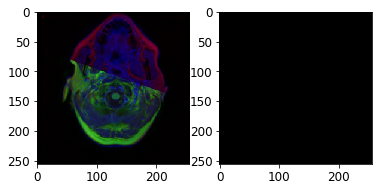

Prediction:


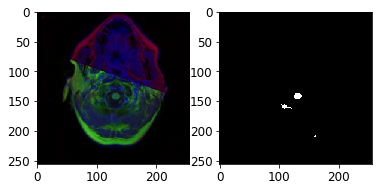

Percision:  0.0  Recall:  0.0




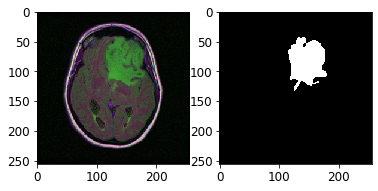

Prediction:


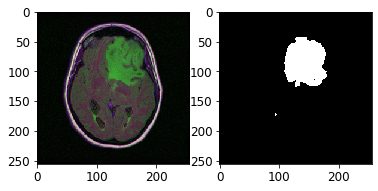

Percision:  0.8209116439835817  Recall:  0.013190093545531856




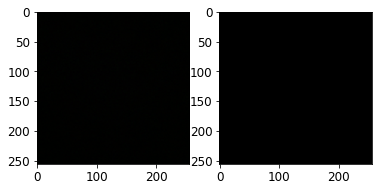

Prediction:


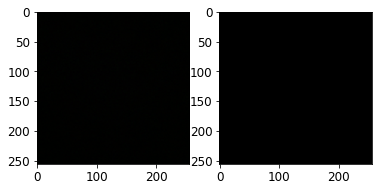

Percision:  1  Recall:  0.0




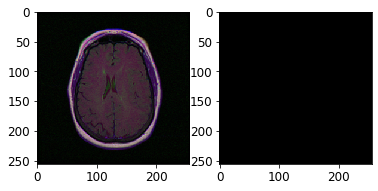

Prediction:


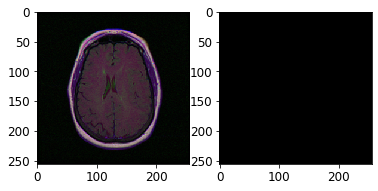

Percision:  1  Recall:  0.0




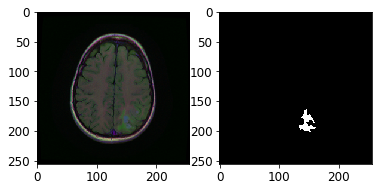

Prediction:


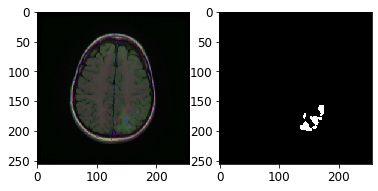

Percision:  0.4421768707482993  Recall:  0.0009024800846942849




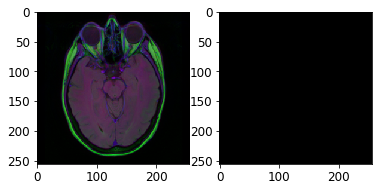

Prediction:


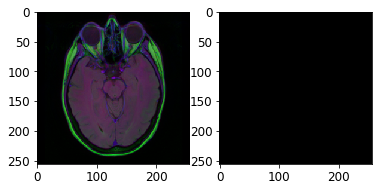

Percision:  0.0  Recall:  0.0




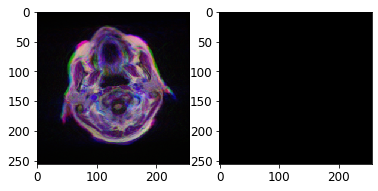

Prediction:


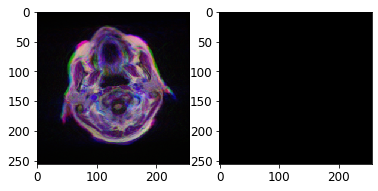

Percision:  1  Recall:  0.0




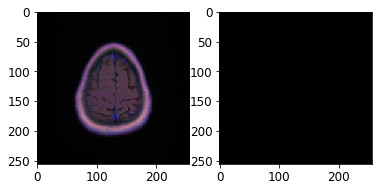

Prediction:


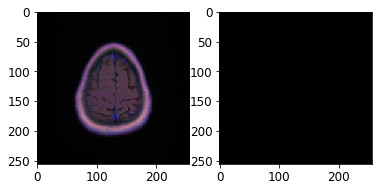

Percision:  1  Recall:  0.0




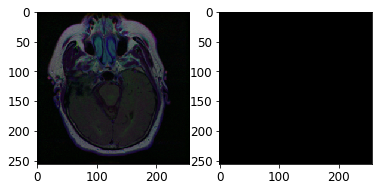

Prediction:


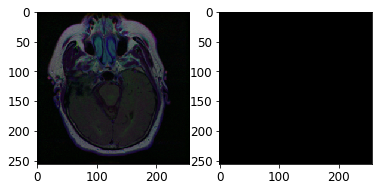

Percision:  1  Recall:  0.0




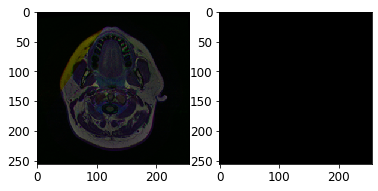

Prediction:


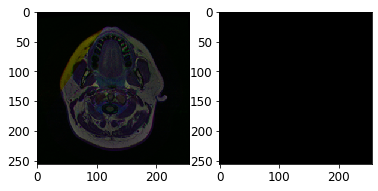

Percision:  1  Recall:  0.0




In [ ]:
y_pred = y_pred.squeeze()

for i in range(20):
  show_pair(X_test[i],y_test[i])
  print('Prediction:')
  show_pair(X_test[i],y_pred[i])
  print('Percision: ',percision(y_test[i],y_pred[i]),' Recall: ',recall(y_test[i],y_pred[i]))
  print('\n')
